# Bayesian Change Point Analysis of COVID-19 Data

Apply the Bayesian changepoint analysis in Bayesian Methods for Hackers to COVID data

https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb

Would be nice if this could be done in Pyro.

## Model

I want to see if I can back out the date virus growth changed, and test its accuracy against the social distancing measures. Depending on how close they are, we can determine how effective social distancing measures were in different countries.  

We have 2 options:

- Model the change in the virus as a change in the exponential growth rate constant: The problem I see here is that when we pass the threshold, we are not starting from $t=0$, so I don't know if this will affect the model. Also don't even know if we're starting at $t=0$, maybe we can start at $t=t$.
    
    
- Model the change in the virus as a change in the number of new cases each day: Tested this and the problem is that the Bayesian model does not know what the underlying data generating process is exponential, so we end up getting a date around when the virus bega. We need to incorporate the exponential growth model into the framework somehow.


### Exponential Growth Model for Virus

$$ y = e^{kt} $$

Where $y$ is the number of infected cases $t$ days after the first infected case and $k$ is the growth rate constant.


### Bayesian Change Point Model

Priors: 

$$ \lambda_1^{(0)} \sim Exp(\alpha) $$    
$$ \lambda_1^{(0)} \sim Exp(\alpha) $$

$$ \tau \sim Uniform(0, 1) $$

Likelihood:

$$ X_i \sim Poi (rate = \lambda) $$

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/jonny/Desktop/Dataset/covid_19_counts-april8.csv")

# use only canada for now
cad = data.loc[data["Country/Region"] == "Canada", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
cad.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
cad = cad.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
cad.date = pd.to_datetime(cad.date)
cad = cad.sort_values(by = "date")

# weird data around April 5th, just remove for now:
cad = cad[cad.date < "2020-04-04"]

cad.tail()

/Users/jonny/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,country,date,confirmed,deaths,recovered
62,Canada,2020-03-30,7398,80,0
63,Canada,2020-03-31,8527,101,0
70,Canada,2020-04-01,9560,109,0
71,Canada,2020-04-02,11284,139,0
72,Canada,2020-04-03,12437,179,0


In [31]:
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0


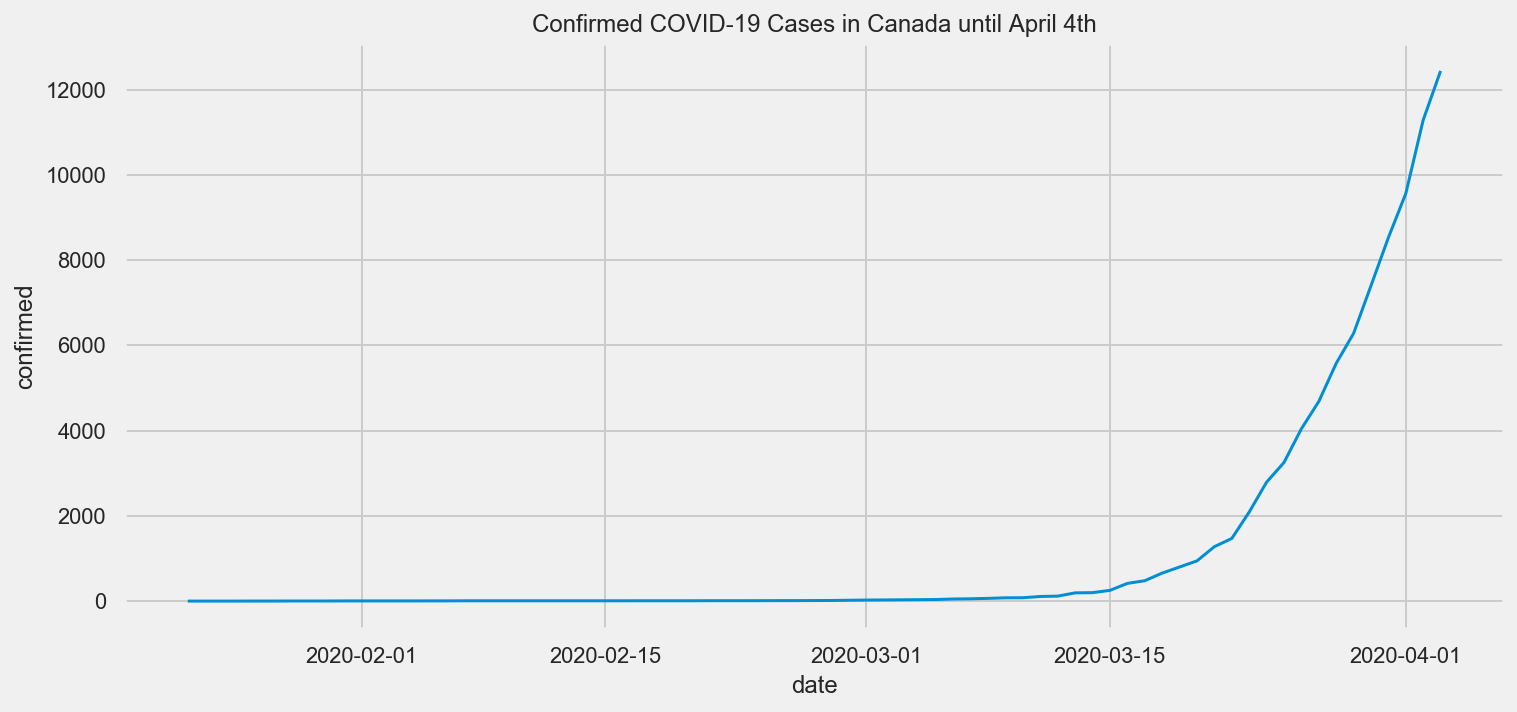

In [36]:
plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= cad
            ).set_title("Confirmed COVID-19 Cases in Canada until April 4th");

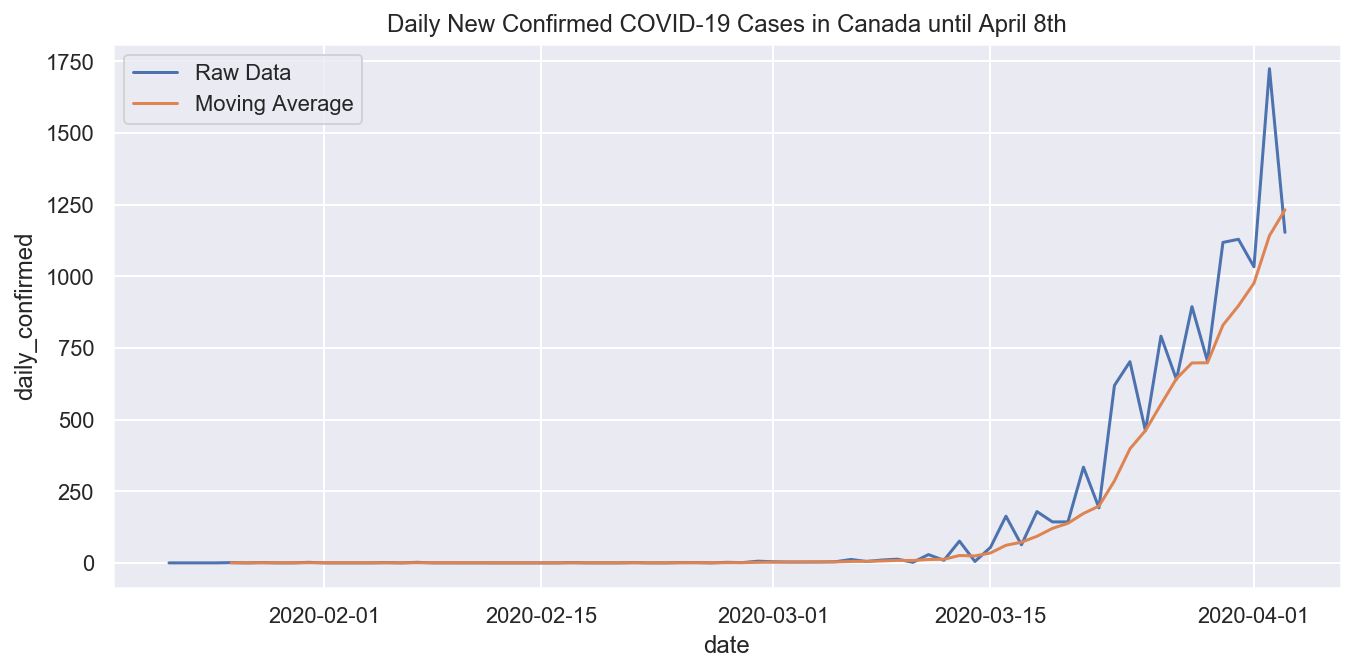

In [4]:
cases_shifted = np.array([0] + list(cad.confirmed[:-1]))
daily_confirmed = np.array(cad.confirmed) - cases_shifted
cad["daily_confirmed"] = daily_confirmed 

# plot daily confirmed cases, along with moving average
plt.figure(figsize=(11, 5))
sns.lineplot(x = cad.date, 
             y = cad.daily_confirmed, 
             label = "Raw Data")

sns.lineplot(x = cad.date, 
             y = cad.daily_confirmed.rolling(window=5).mean(), 
             label = "Moving Average",
             legend = "full").set_title("Daily New Confirmed COVID-19 Cases in Canada until April 8th");

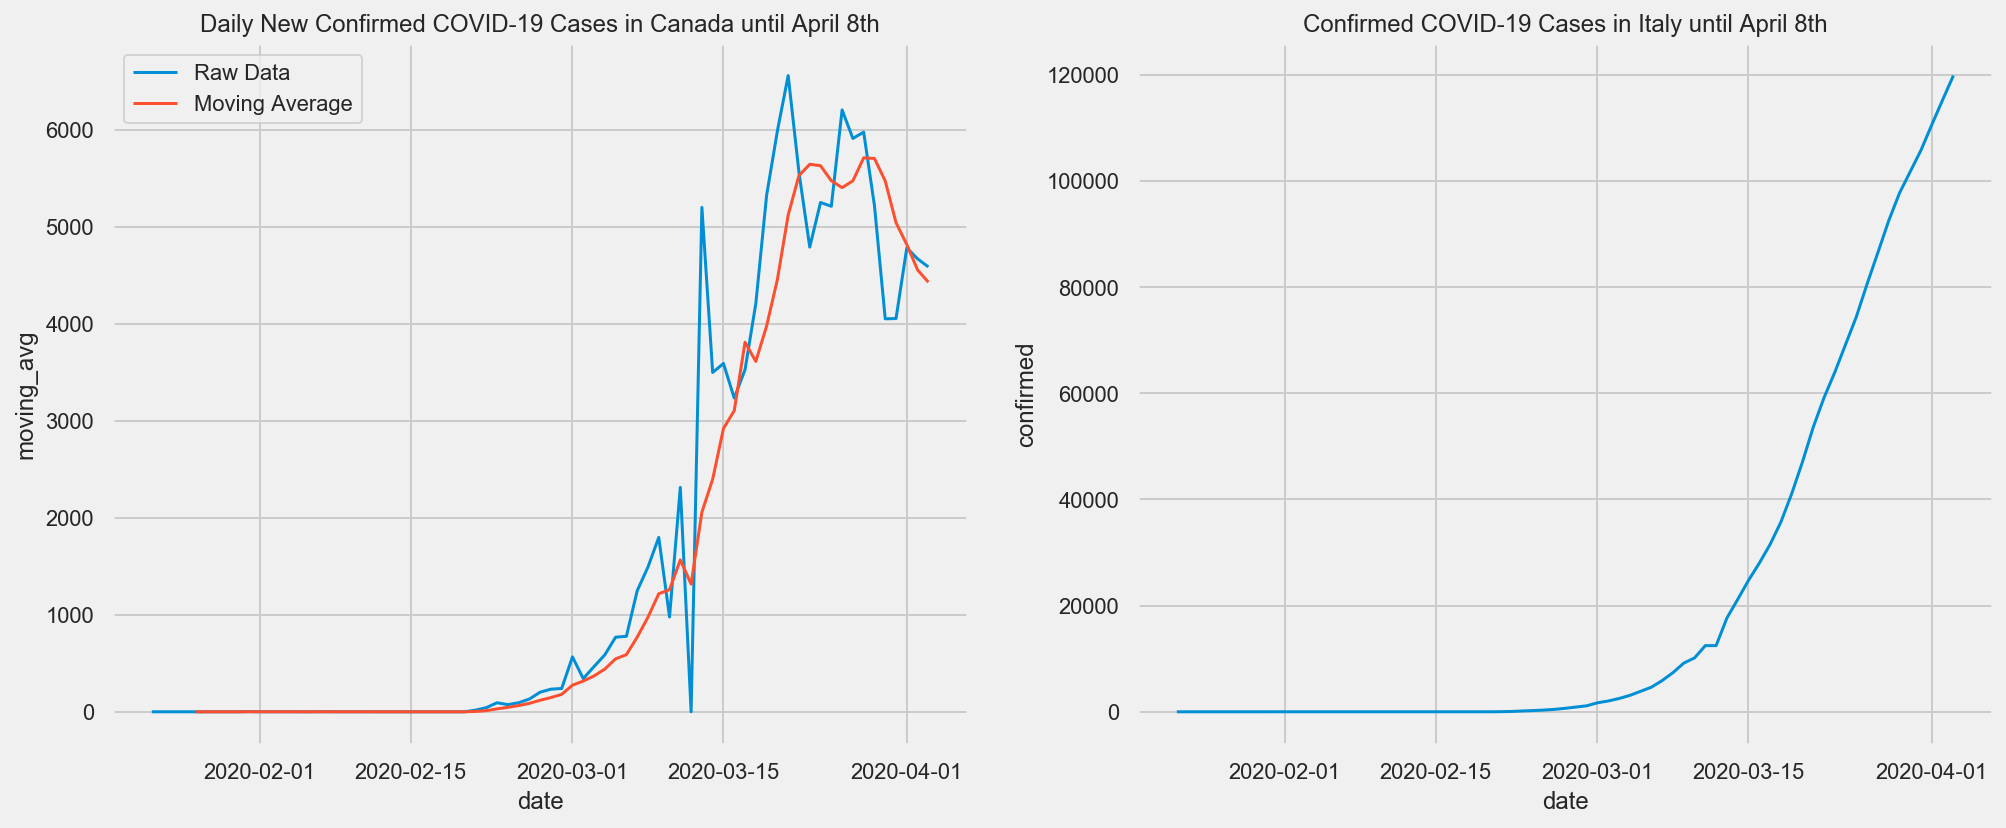

In [148]:
# italy

# use only canada for now
italy = data.loc[data["Country/Region"] == "Italy", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
italy.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
italy = italy.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
italy.date = pd.to_datetime(cad.date)
italy = italy.sort_values(by = "date")

# weird data around April 5th, just remove for now:
#italy = italy[italy.date < "2020-04-04"]

italy.tail()

cases_shifted = np.array([0] + list(italy.confirmed[:-1]))
daily_confirmed = np.array(italy.confirmed) - cases_shifted
italy["daily_confirmed"] = daily_confirmed 

italy["moving_avg"] = italy.daily_confirmed.rolling(window=5).mean()

fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
#plt.figure(figsize=(11, 5))
sns.lineplot(x = italy.date, 
             y = italy.daily_confirmed, 
             label = "Raw Data",
             ax = ax[0])

sns.lineplot(x = italy.date, 
             y = italy.moving_avg, 
             label = "Moving Average",
             legend = "full",
             ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in Canada until April 8th")

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= italy,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th");

### TFP Model from BMH

In [149]:
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
matplotlib_style = 'fivethirtyeight' 
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

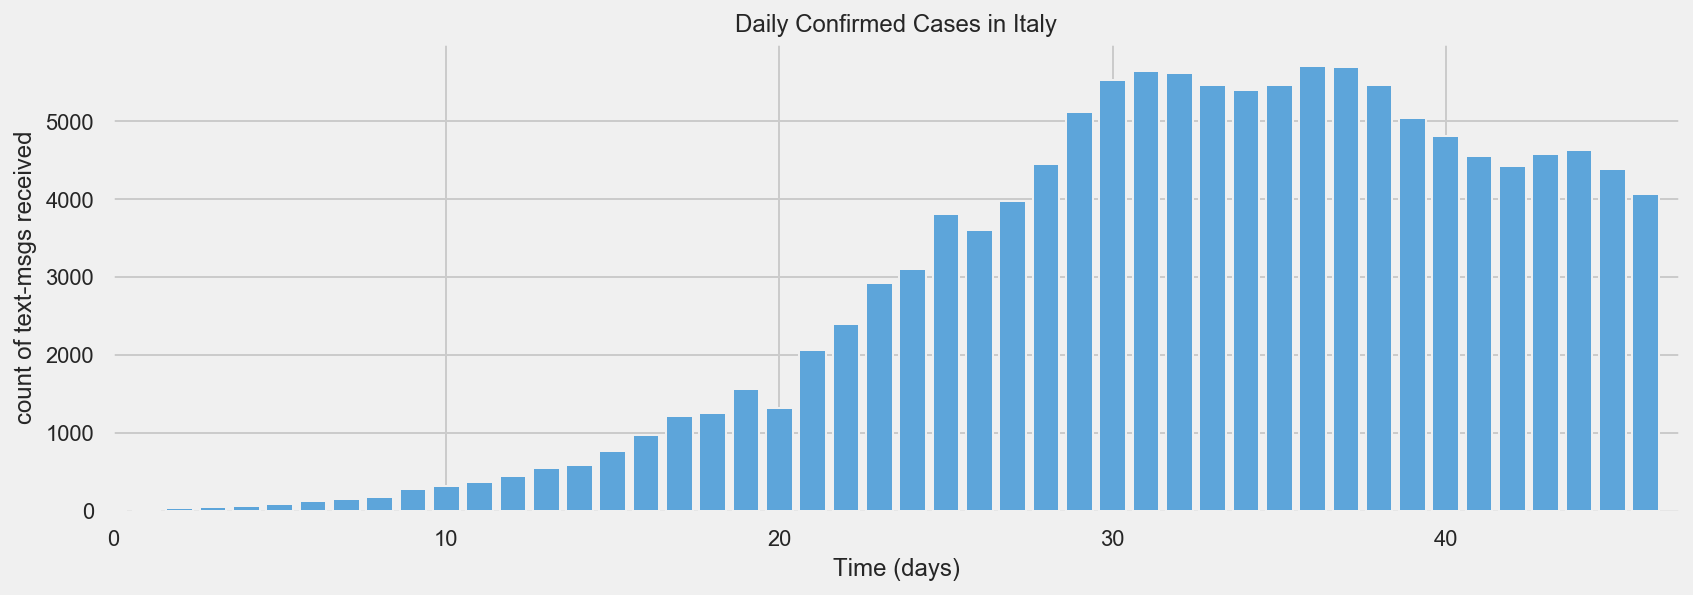

In [156]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)

##### test new count data
#count_data = tf.constant(cad[cad.date > "2020-03-01"].daily_confirmed, dtype = tf.float32)
count_data = tf.constant(italy.moving_avg[30:], dtype = tf.float32)

n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Daily Confirmed Cases in Italy")
plt.xlim(0, n_count_data[0].numpy());

In [157]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

In [158]:
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
num_results = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [159]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))

acceptance rate: 0.6664999723434448
final step size: 0.004839919973164797


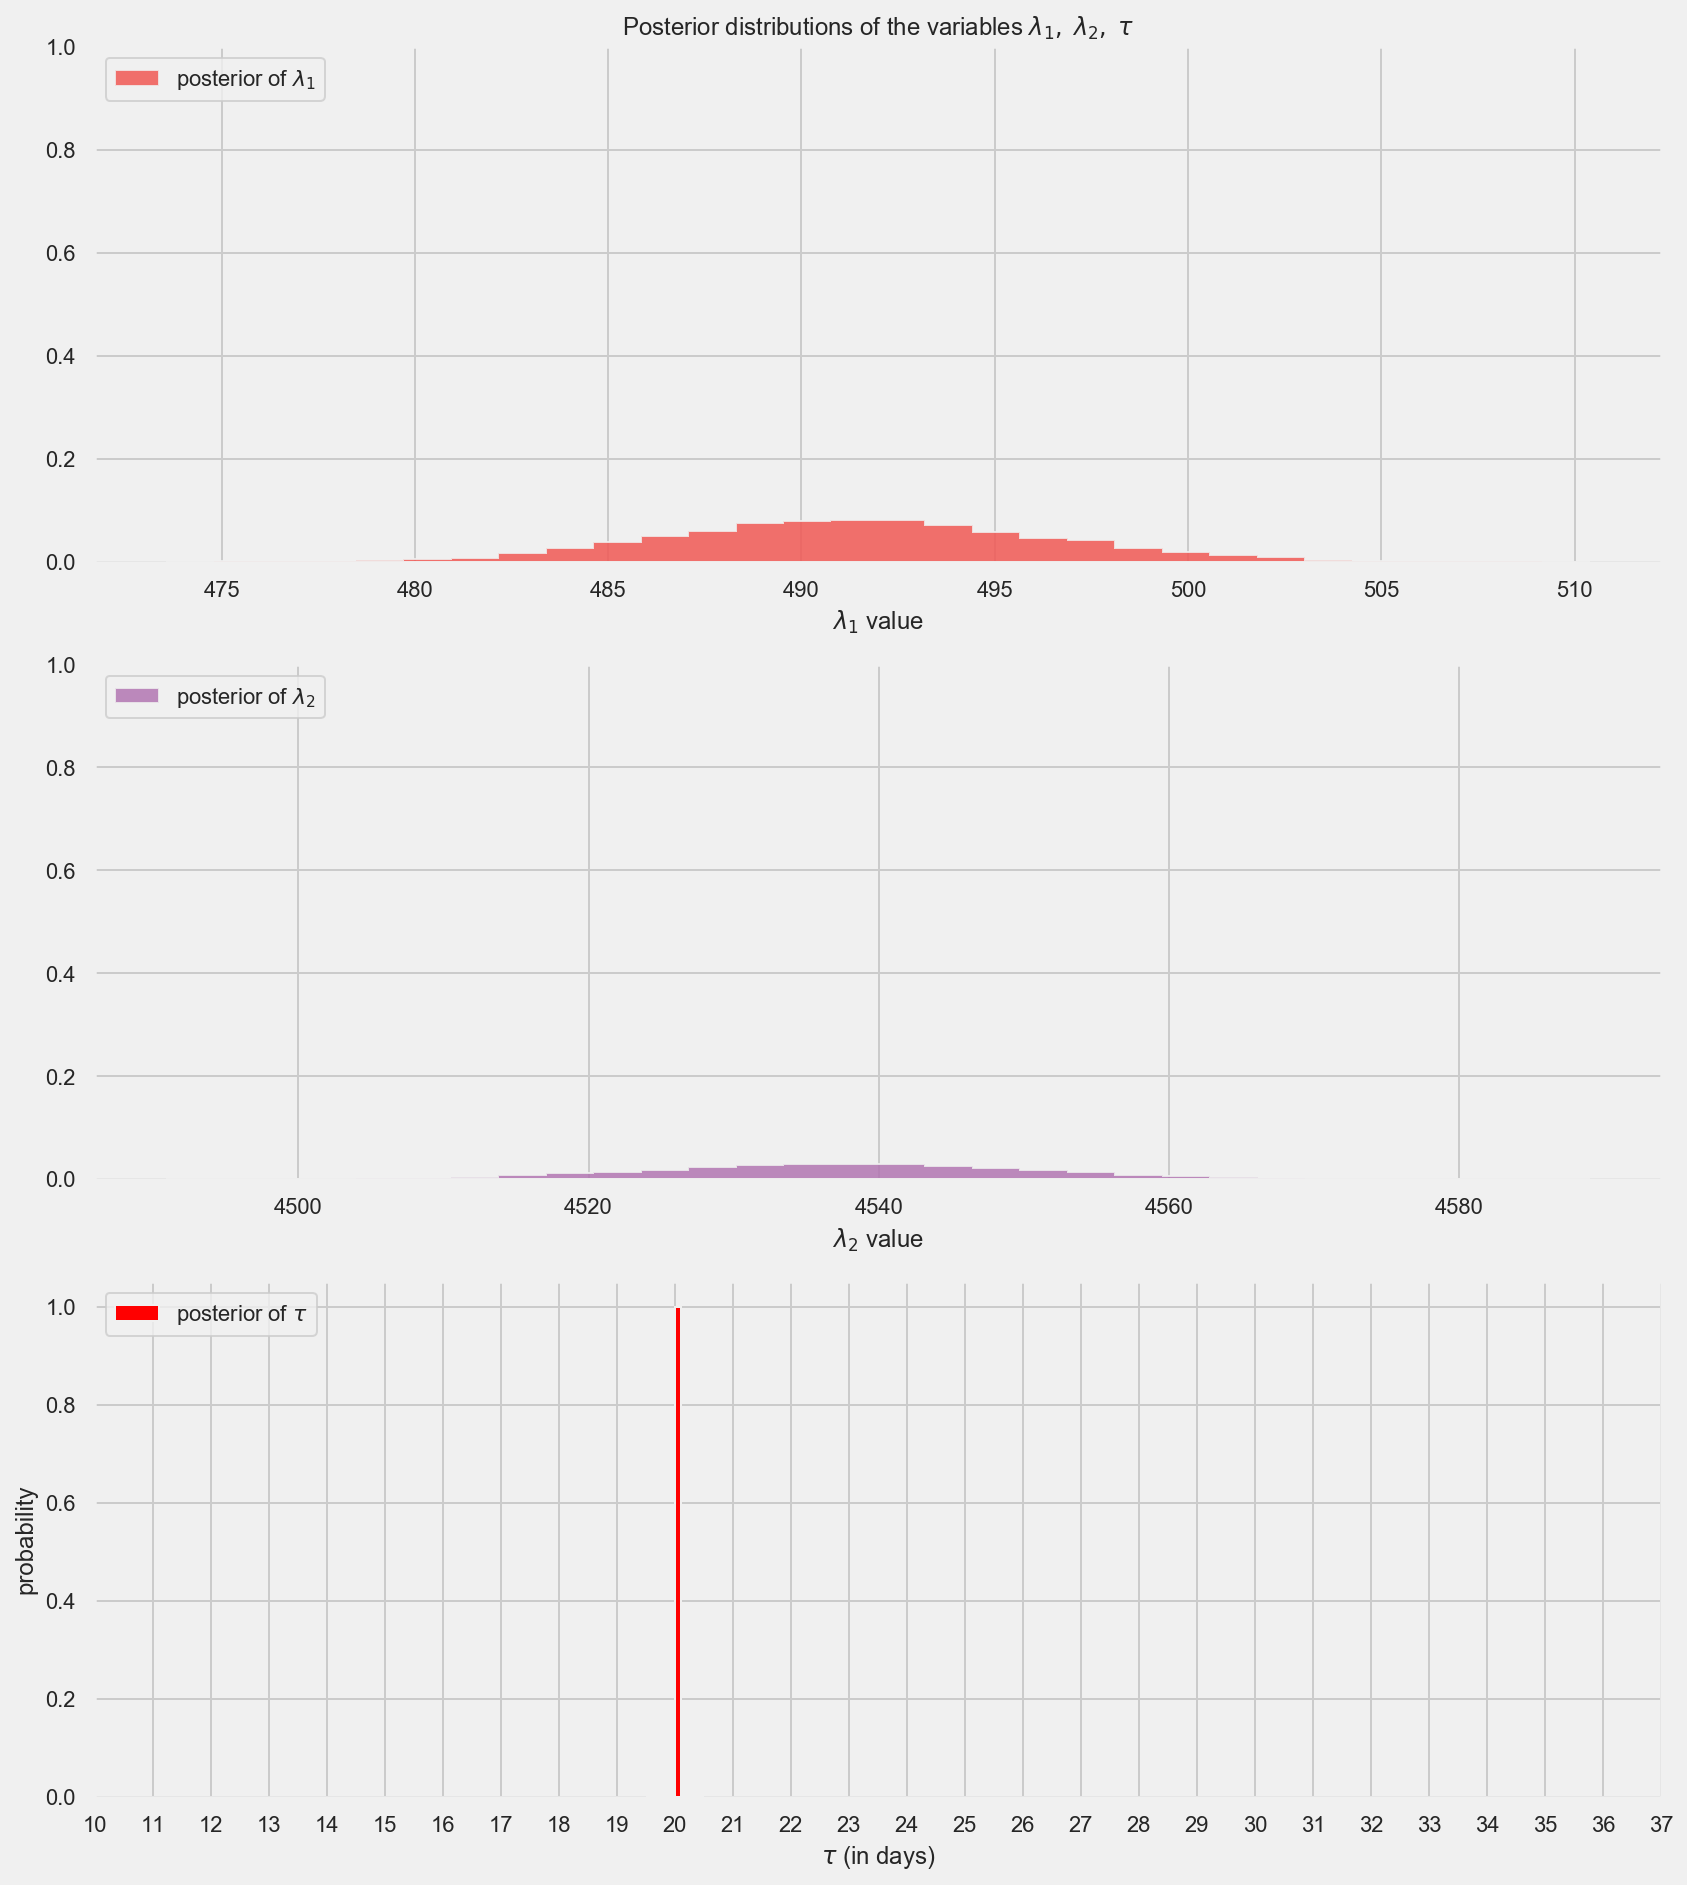

In [160]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples.numpy().astype(int), 
         alpha=1,
         label=r"posterior of $\tau$",
         color="red", 
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
plt.xlim([10, len(count_data)-10])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

2020-03-02 00:00:00


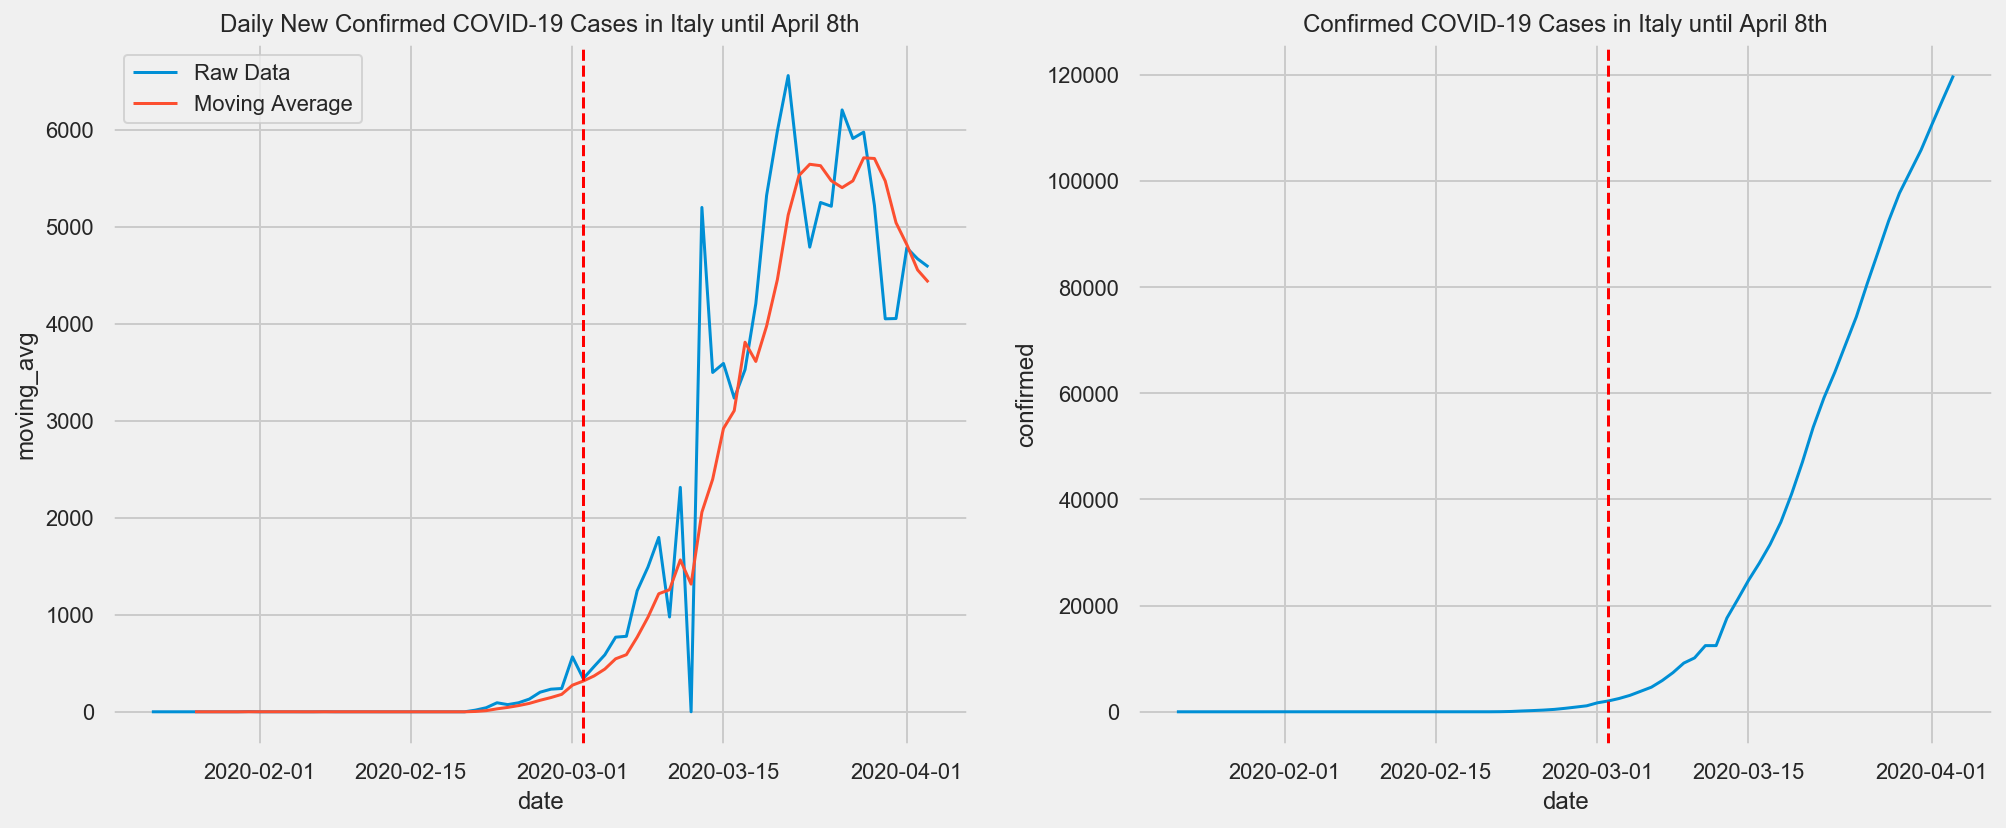

In [169]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
#plt.figure(figsize=(11, 5))
sns.lineplot(x = italy.date, 
             y = italy.daily_confirmed, 
             label = "Raw Data",
             ax = ax[0])

sns.lineplot(x = italy.date, 
             y = italy.moving_avg, 
             label = "Moving Average",
             legend = "full",
             ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in Italy until April 8th")

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= italy,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th")

ax[0].axvline(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)], color="red", linestyle="--")
ax[1].axvline(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)], color="red", linestyle="--")
print(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)]);